In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as int
from scipy.optimize import root_scalar 
from scipy.special import erf
from tqdm import tqdm
import multiprocessing as mp
import csv
import numba as nb

In [3]:
# def beta_kappa_correlations(N,row,column,gamma, sigma):
#     correlation_values_b_k = np.zeros((N,2), dtype = float)
    
#     for i in range(N):
#         #Generate random normal values
#         rand_val_1 = np.random.normal(0, 1)
#         rand_val_2 = np.random.normal(0, 1)
    
#         beta_i = rand_val_1*np.sqrt(row/N)
#         beta_i *= sigma/np.sqrt(N)
#         #Different cases for when r=0 as wd usually do DIV by 0
#         if (row ==0 and gamma==0):
#             kappa_i = np.sqrt(column/N)*rand_val_2
#             kappa_i *= sigma/np.sqrt(N)
#         else: 
#             kappa_i = gamma*rand_val_1/(np.sqrt(row*N)) + (np.sqrt(column-gamma*gamma/row)*rand_val_2)/np.sqrt(N)
#             kappa_i *= sigma/np.sqrt(N)

        
#         correlation_values_b_k[i,0] = beta_i
#         correlation_values_b_k[i,1] = kappa_i

#     return correlation_values_b_k


def beta_kappa_correlations(N,row,column,gamma, sigma):
    correlation_values_b_k = np.zeros((N, 2), dtype=float)
    
    # Precompute constants
    sqrt_row_N = np.sqrt(row / N)
    sqrt_N = np.sqrt(N)
    sigma_sqrt_N = sigma / sqrt_N
    sqrt_column_N = np.sqrt(column / N)
    
    # Generate all random values at once
    rand_vals_1 = np.random.normal(0, 1, N)
    rand_vals_2 = np.random.normal(0, 1, N)
    
    
    
    # Compute kappa_i
    if row == 0 and gamma == 0:
        kappa_i = rand_vals_2 * sqrt_column_N * sigma_sqrt_N
    else:
        sqrt_column_gamma2_row = np.sqrt(column - gamma * gamma / row) / sqrt_N
        kappa_i = (gamma * rand_vals_1 / (np.sqrt(row * N)) + 
                   sqrt_column_gamma2_row * rand_vals_2) * sigma_sqrt_N
    
    # Compute beta_i
    beta_i = rand_vals_1 * sqrt_row_N * sigma_sqrt_N
    # Assign values to the correlation matrix
    correlation_values_b_k[:, 0] = beta_i
    correlation_values_b_k[:, 1] = kappa_i
    
    return correlation_values_b_k

# def omega_correlations(N,row,column,gamma,big_gamma, sigma):
#     correlation_values_omega = np.zeros((N,N), dtype = float)
#     #temp variables to make below calulation clearer
#     temp1 = 1.0-(row+column)/N
#     temp2 = big_gamma - 2.0*gamma/N
#     for i in range(N):
#         for j in range(i):
#             rand_val_1 = np.random.normal(0, 1)
#             rand_val_2 = np.random.normal(0, 1)
                
#             correlation_values_omega[i,j] = rand_val_1*np.sqrt(temp1)
#             correlation_values_omega[i,j] *= sigma/np.sqrt(N)

#             correlation_values_omega[j,i] = rand_val_1*(temp2)/(np.sqrt(temp1)) + rand_val_2*np.sqrt(temp1 - (temp2*temp2)/temp1)
#             correlation_values_omega[j,i] *= sigma/np.sqrt(N)
#     return correlation_values_omega

def omega_correlations(N, row, column, gamma, big_gamma, sigma):
    # Precompute constants
    temp1 = 1.0 - (row + column) / N
    temp2 = big_gamma - 2.0 * gamma / N
    sigma_sqrt_N = sigma / np.sqrt(N)
    sqrt_temp1 = np.sqrt(temp1)
    sqrt_temp1_temp2 = np.sqrt(temp1 - (temp2 * temp2) / temp1)
    
    # Generate all random values at once
    rand_vals_1 = np.random.normal(0, 1, (N, N))
    rand_vals_2 = np.random.normal(0, 1, (N, N))
    
    # Compute correlation values using matrix operations
    lower_triangle_indices = np.tril_indices(N, -1)
    
    correlation_values_omega = np.zeros((N, N), dtype=float)
    
    correlation_values_omega[lower_triangle_indices] = rand_vals_1[lower_triangle_indices] * sqrt_temp1 * sigma_sqrt_N
    correlation_values_omega.T[lower_triangle_indices] = (rand_vals_1[lower_triangle_indices] * temp2 / sqrt_temp1 + 
                                                          rand_vals_2[lower_triangle_indices] * sqrt_temp1_temp2) * sigma_sqrt_N
    
    return correlation_values_omega

@nb.jit(nopython = True) # delete this line if you dont have numba, its just for efficiency
# def may_matrix(N, mu, bk_array, omega_matrix): 
#     result = np.zeros((N, N))
#     for i in range(N):
#         for j in range(N):
#             z_ij = bk_array[i,0] + bk_array[j,1] + omega_matrix[i,j]
#             result[i,j] = mu/N + z_ij    
#     np.fill_diagonal(result,0) # Forces diagonal components to = 0 due to LV eqn below
#     return result

def may_matrix(N, mu, bk_array, omega_matrix): 
    # Compute z_ij using broadcasting
    z_ij = bk_array[:, 0][:, np.newaxis] + bk_array[:, 1] + omega_matrix
    
    # Compute the result matrix
    result = mu / N + z_ij
    
    # Set the diagonal elements to zero
    np.fill_diagonal(result, 0)
    
    return result

def lotka_volterra(X, t, alpha):
    dxdt = X*(1 -X + alpha @ X)
    if np.any(dxdt>10**3):
        X = np.zeros((X.shape))
        dxdt = np.zeros((dxdt.shape))
        raise Exception
    return dxdt

In [4]:
def distance_measure(x_1, x_2):
    diff = np.power((x_1-x_2),2)
    N_average = np.mean(diff,axis = 0)
    T_average = np.mean (N_average)
    diff_norm = np.power(x_1,2)
    N_average_norm = np.mean(diff_norm,axis = 0)
    T_average_norm = np.mean (N_average_norm)
    return T_average/T_average_norm

def run_lv_distance(args):
    SIGMA, BIG_GAMMA, ROW, GAMMA, COLUMN, MU, iterations, N = args
    distances = []
    diverge = 0
        #Run-time constants
    T_MIN = 0.0
    T_MAX = 100.0
    DT = 0.01

    # while len(distances) == 0:
        # T_MAX += 100
    for _ in range(iterations): 
        alpha = may_matrix(N, MU, beta_kappa_correlations(N,ROW,COLUMN,GAMMA, SIGMA), omega_correlations(N,ROW,COLUMN,GAMMA,BIG_GAMMA, SIGMA))
        x_0 = np.random.uniform(.5,2,N) #start at x=1, doesn't matter
        x_1 = np.random.uniform(.5,2,N) #start at x=1, doesn't matter
        t = np.arange(T_MIN, T_MAX+DT, DT)
        try:
            integrate_1 = int.odeint(lotka_volterra, x_0, t, args = (alpha,))
            integrate_2 = int.odeint(lotka_volterra, x_1, t, args = (alpha,))
            distances.append(distance_measure(integrate_1, integrate_2))
        except:
            diverge += 1
        # if T_MAX > 200:
        #     break
    if len(distances) == 0:
        return np.nan
    else:
        return sum(distances)/len(distances)

In [5]:
def calculate_distances_vary_r(BIG_GAMMA, GAMMA, COLUMN, MU, iterations, N, row_arr, row_sigma_dict, filename):
    args_list = []
    for ROW in row_sigma_dict:
        for SIGMA in row_sigma_dict[BIG_GAMMA]:
            args_list.append((SIGMA, BIG_GAMMA, ROW, GAMMA, COLUMN, MU, iterations, N))
    
    if __name__ == '__main__':
        num_processes = mp.cpu_count()
        with mp.Pool(processes=num_processes) as pool:
            results = list(tqdm(pool.imap(run_lv_distance, args_list), total=len(args_list)))
        pool.close()
        pool.join()
        # process the results
        values = [np.zeros((len(row_sigma_dict[ROW]))) for ROW in row_arr]
        opper_line = np.zeros(len(row_arr))
        mifty_line = np.zeros(len(row_arr))

        for i, args in enumerate(args_list):
            SIGMA, BIG_GAMMA, ROW, GAMMA, COLUMN, MU, iterations, N = args
            jj = np.where(np.array(row_sigma_dict[ROW]) == SIGMA)[0][0]
            ii = np.where(np.array(row_arr) == ROW)[0][0]
            values[ii][jj] = results[i]

        # save the results to a CSV file
        header = ['VARIANCE', 'ROW', 'DISTANCE'] 
        with open(filename, 'w', newline='') as f: 
            writer = csv.writer(f)
            writer.writerow(['BG', BIG_GAMMA])
            writer.writerow(['GAMMA', GAMMA])
            writer.writerow(['COLUMN', COLUMN])
            writer.writerow(['MU', MU])
            writer.writerow(header)
            for ii, ROW in enumerate(row_arr):
                mifty = True
                opper = True
                for jj, SIGMA in enumerate(row_sigma_dict[ROW]):
                    writer.writerow([SIGMA**2, ROW, values[ii][jj]])
                    if (values[ii][jj] == -1) and mifty:
                        mifty_line[ii] = SIGMA**2
                        mifty = False
                    if (values[ii][jj] > 0.1) and opper:
                        opper_line[ii] = SIGMA**2
                        opper = False

In [48]:
def calculate_distances_vary_gamma(BIG_GAMMA, ROW, COLUMN, MU, iterations, N, gamma_arr, gamma_sigma_dict, filename):
    args_list = []
    for GAMMA in gamma_sigma_dict:
        for SIGMA in gamma_sigma_dict[GAMMA]:
            args_list.append((SIGMA, BIG_GAMMA, ROW, GAMMA, COLUMN, MU, iterations, N))
    
    if __name__ == '__main__':
        num_processes = mp.cpu_count()
        with mp.Pool(processes=num_processes) as pool:
            results = list(tqdm(pool.imap(run_lv_distance, args_list), total=len(args_list)))
        pool.close()
        pool.join()
        # process the results
        values = [np.zeros((len(gamma_sigma_dict[GAMMA]))) for GAMMA in gamma_arr]
        opper_line = np.zeros(len(gamma_arr))
        mifty_line = np.zeros(len(gamma_arr))

        for i, args in enumerate(args_list):
            SIGMA, BIG_GAMMA, ROW, GAMMA, COLUMN, MU, iterations, N = args
            jj = np.where(np.array(gamma_sigma_dict[GAMMA]) == SIGMA)[0][0]
            ii = np.where(np.array(gamma_arr) == GAMMA)[0][0]
            values[ii][jj] = results[i]

        # save the results to a CSV file
        header = ['VARIANCE', 'GAMMA', 'DISTANCE'] 
        with open(filename, 'w', newline='') as f: 
            writer = csv.writer(f)
            writer.writerow(['BG', BIG_GAMMA])
            writer.writerow(['ROW', ROW])
            writer.writerow(['COLUMN', COLUMN])
            writer.writerow(['MU', MU])
            writer.writerow(header)
            for ii, GAMMA in enumerate(gamma_arr):
                mifty = True
                opper = True
                for jj, SIGMA in enumerate(gamma_sigma_dict[GAMMA]):
                    writer.writerow([SIGMA**2, GAMMA, values[ii][jj]])
                    if (values[ii][jj] == -1) and mifty:
                        mifty_line[ii] = SIGMA**2
                        mifty = False
                    if (values[ii][jj] > 0.1) and opper:
                        opper_line[ii] = SIGMA**2
                        opper = False

In [104]:
iterations = 200
N = 200
ROW =1.0
MU = -10.0
COLUMN = 2.0 # GREATER THAM GAMMA^2/R
BIG_GAMMA = 0.0 # Predator Prey

gamma_sigma_dict = {-1: np.sqrt(np.arange(1,8,0.2)),
                 0: np.sqrt(np.arange(1,8,0.2)),
                 1: np.sqrt(np.arange(1,8,0.2))}

gamma_arr = list(gamma_sigma_dict.keys())
filename = 'gamma_distance_long.csv'
calculate_distances_vary_gamma(BIG_GAMMA, ROW, COLUMN, MU, iterations, N, gamma_arr, gamma_sigma_dict, filename)

100%|██████████| 105/105 [06:05<00:00,  3.48s/it]


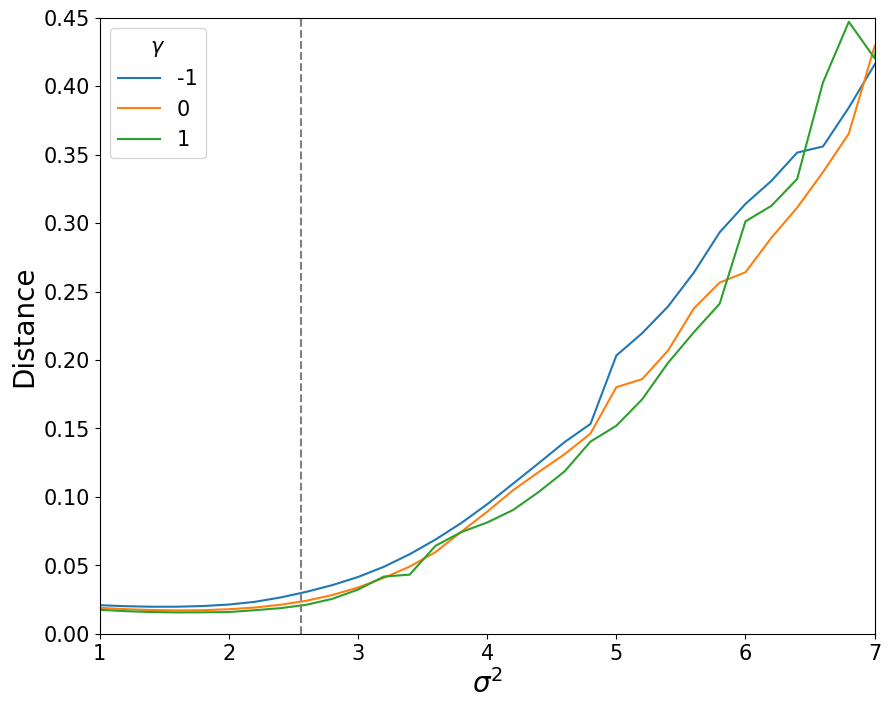

In [109]:
import csv
import matplotlib.pyplot as plt

# Read the CSV file
data = {}
with open('gamma_distance_long.csv', 'r') as f:
    reader = csv.reader(f)
    for gamma in reader:
        if gamma[0] in ['BG', 'ROW', 'COLUMN', 'MU', 'VARIANCE']:
            continue
        variance = float(gamma[0])
        gamma_value = float(gamma[1])
        distance = float(gamma[2])
        if gamma_value not in data:
            data[gamma_value] = {'variances': [], 'distances': []}
        data[gamma_value]['variances'].append(variance)
        data[gamma_value]['distances'].append(distance)


# Plot the data
plt.figure(figsize=(10, 8))
for gamma_value, values in data.items():
    plt.plot(values['variances'], values['distances'], label=f'{gamma_value:.1g}')
plt.xlabel(r'$\sigma^2$', fontsize=20)
plt.ylabel('Distance', fontsize = 20)
plt.legend(title =r'$\gamma$', title_fontsize = 15, fontsize = 15)
# plt.grid(True)
# plt.ylim(0,0.2)
# plt.ylim(0,0.0000000001)
plt.ylim(0,0.45)
plt.xlim(1,7)
plt.axvline(2.56, color='grey', linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('gamma_distance.png', dpi = 500)
plt.show()

In [6]:
iterations = 5
N = 200

MU = -6.0
COLUMN = 0.0 # GREATER THAM GAMMA^2/R
BIG_GAMMA = 0.0 # Predator Prey
GAMMA  = 0.0


row_sigma_dict = {0: np.sqrt(np.arange(1.6,4.6,0.2)),
                 1: np.sqrt(np.arange(1.6,4.6,0.2)),
                 5: np.sqrt(np.arange(1.6,4.6,0.2))}
# row_sigma_dict = {0: np.sqrt(np.arange(0,2.5,0.05)),
#                  1: np.sqrt(np.arange(0,2.5,0.05)),
#                  5: np.sqrt(np.arange(0,2.5,0.05))}
row_arr = list(row_sigma_dict.keys())
filename = 'R_distance.csv'
calculate_distances_vary_r(BIG_GAMMA, GAMMA, COLUMN, MU, iterations, N, row_arr, row_sigma_dict, filename)

100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


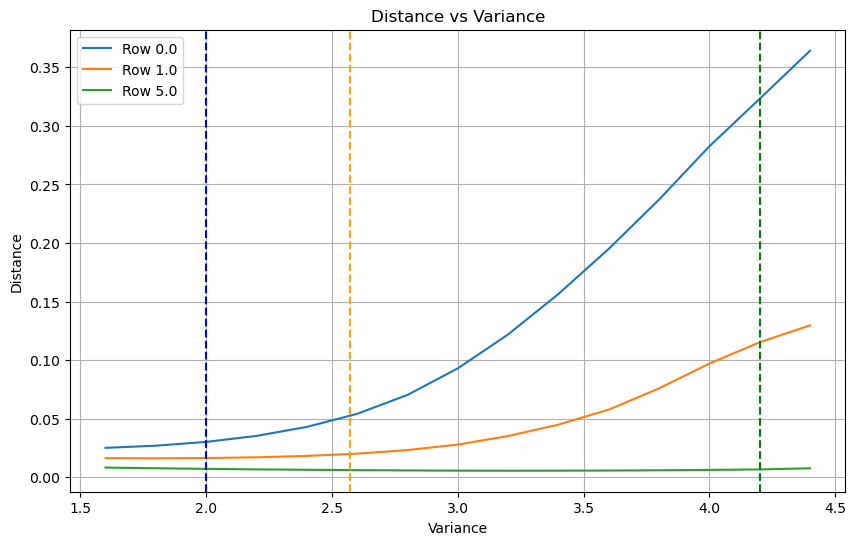

In [86]:
import csv
import matplotlib.pyplot as plt

# Read the CSV file
data = {}
with open('R_distance.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] in ['BG', 'GAMMA', 'COLUMN', 'MU', 'VARIANCE']:
            continue
        variance = float(row[0])
        row_value = float(row[1])
        distance = float(row[2])
        if row_value not in data:
            data[row_value] = {'variances': [], 'distances': []}
        data[row_value]['variances'].append(variance)
        data[row_value]['distances'].append(distance)

# for row_value, values in data.items():
#     first_distance = values['distances'][0]
#     values['distances'] = [d - first_distance for d in values['distances']]


# Plot the data
plt.figure(figsize=(10, 6))
for row_value, values in data.items():
    plt.plot(values['variances'], values['distances'], label=f'Row {row_value}')
plt.xlabel('Variance')
plt.ylabel('Distance')
plt.title('Distance vs Variance')
plt.legend()
plt.grid(True)
# plt.xlim(0,2)
# plt.ylim(0,0.0000000001)
plt.axvline(2, color='b', linestyle='--')
plt.axvline(2.57, color='orange', linestyle='--')
plt.axvline(4.2, color='green', linestyle='--')

plt.show()

In [12]:
def W_calc(delta):
    output = np.zeros((delta.size,3), dtype = float)
    for i in range(0,delta.size):
        output[i,0] = 0.5*(1 + erf(delta[i]/np.sqrt(2)))
        output[i,1] = 0.5*((np.sqrt(2/np.pi)*np.exp(-(delta[i]**2)/2))+delta[i]*(1 + erf(delta[i]/np.sqrt(2))))
        output[i,2] = output[i,0] + delta[i]*output[i,1]
    return output

def Variance(w,big_gamma,delta,r): #This function calculates the variance of the set of the data in terms of the w variables
    var_array = np.zeros((delta.size), dtype = float)
    for i in range(0,delta.size):
        var_array[i] = w[i,2]/((w[i,2] + ((big_gamma * w[i,0])/(1 + r*(w[i,1]**2/w[i,2]))))**2 * (1 + r*(w[i,1]**2/w[i,2])))
    return var_array


def R_theory(w,bg,delta, sigma):
    r_array = np.zeros((delta.size),dtype=float)
    for i in range(0,delta.size):
        #b = 2*bg*w[i,0]-np.power(sigma,-2)
        #c = np.power(bg*w[i,0],2)
        #func = lambda x:x**2 +b*x + c
        #result = root_scalar(func,  bracket=[-float('inf'), float('inf')])
        #if result.converged:
        #  row_val = (result.root-w[i,2])/np.power(w[i,1],2)
        #    r_array[i] = row_val
        r2 = (np.power(sigma,-2)-w[i,2])*np.power(w[i,1],-2)
        if r2>0:
            r_array[i] = r2
    return r_array

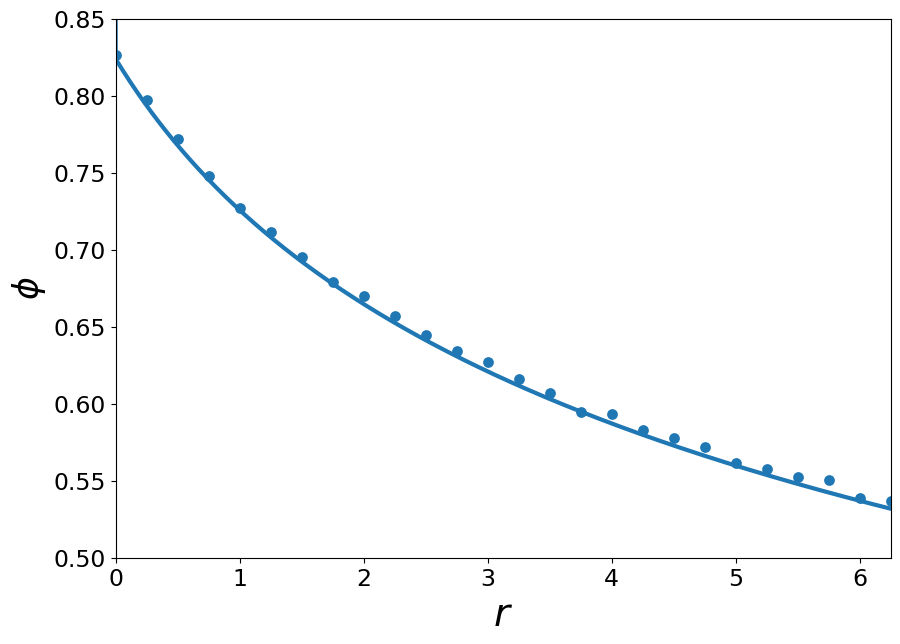

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
# Parameter Constants
delta = np.linspace(0,5, num = 100000)
w_array = W_calc(delta)
# Load the CSV file into a DataFrame
df = pd.read_csv('row_phi.csv')

# Extract the relevant columns for plotting
row_array = df['Row']
fraction_values = df['Fraction']
# Create a scatter plot
plt.figure(figsize=(10, 7))
SIGMA = 0.75
plt.plot(R_theory(w_array, BIG_GAMMA, delta, SIGMA), w_array[:, 0], linewidth=3)
plt.scatter(row_array, fraction_values, s=45)


# Set plot labels and limits
plt.xlabel('$r$', fontsize=28)
plt.ylabel('$\\phi$', fontsize=25)
plt.xlim(0, 6.25)
plt.ylim(0.5, 0.85)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('row_phi.png', dpi=500)
# Show the plot
plt.show()